In [16]:
%pylab inline
from pylab import *
import h5py
import codecs,string,os,sys,os.path,glob,re

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


The CLSTM command line tools take their training data in HDF5 files (you will evenutally also be able to train directly from images saved on disk, as in ocropy, but that's not quite implemented yet). This illustrates how to store images into an HDF5 file and then how to run the `clstmctc` training tool on the data.

# The UW3-500 Dataset

We illustrate loading data with the `uw3-500.tgz` dataset, available from `tmbdev.net`.

In [17]:
!test -f uw3-500.tgz || wget -nd http://www.tmbdev.net/ocrdata/uw3-500.tgz

Let's untar the file unless it has already been untarred.

In [18]:
!test -d book || tar -zxvf uw3-500.tgz

The UW3-500 dataset is a collection of text line images and corresponding ground truth transcription. It's organized as a directory tree of the form `book/<page_no>/<line_id>.bin.png` etc.

In [19]:
!ls book/0005/010001.*

book/0005/010001.bin.png  book/0005/010001.gt.txt


# Codecs

Let's start by computing the character set used by this training data.

In [20]:
charset = set()
for fname in glob.glob("book/*/*.txt"):
    with codecs.open(fname,"r","utf-8") as stream:
        chars = stream.read()
    charset = charset.union(set(chars))

We aren't recognizing newlines, but we need the NUL character for an epsilon transition during CTC training.

In [21]:
charset.remove('\n')
charset.add('\0')

In [22]:
charset = sorted(list(charset))
print charset

['\x00', u' ', u'!', u'"', u'$', u'%', u'&', u"'", u'(', u')', u',', u'-', u'.', u'/', u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9', u':', u';', u'<', u'=', u'A', u'B', u'C', u'D', u'E', u'F', u'G', u'H', u'I', u'J', u'K', u'L', u'M', u'N', u'O', u'P', u'Q', u'R', u'S', u'T', u'U', u'V', u'W', u'X', u'Y', u'Z', u'[', u']', u'`', u'a', u'b', u'c', u'd', u'e', u'f', u'g', u'h', u'i', u'j', u'k', u'l', u'm', u'n', u'o', u'p', u'q', u'r', u's', u't', u'u', u'v', u'w', u'x', u'y', u'z']


In constructing the database, we store a codec; the codec maps class labels back to unicode codepoints.

In [23]:
codec = array([ord(c) for c in charset],'i')
encode = {c:i for i,c in enumerate(charset)}
print codec

[  0  32  33  34  36  37  38  39  40  41  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  93  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122]


# HDF5 Files

We're using the `h5py` library to create and access HDF5 datafiles from Python. There is another library, `tables`, that you can also use.

In [24]:
h5 = h5py.File("uw3-500.h5", "w")

Let's start by writing the codec; this is simply storing a fixed size array.

In [25]:
h5.create_dataset("codec", codec.shape, dtype=int)
h5["codec"][:] = codec

Text line images and transcripts are variable length, so we need HDF5 variable length types. This is how that is done in h5py.

Note that these types are not supported in older versions of `h5py`; the versions installed via `pip` seem to be up-to-date enough.

In [26]:
vlen_int = h5py.special_dtype(vlen=np.dtype('int32'))
vlen_float = h5py.special_dtype(vlen=np.dtype('float32'))
vlen_str = h5py.special_dtype(vlen=str)

The `images` dataset contains the image data, and the `images_dims` array contains the shape of those images (HDF5 doesn't have arrays of multidimensional variable-sized arrays, only arrays of variable-sized 1D arrays). If the images were all the same shape, we could simply store them as a resizable but otherwise rectangular array.

In [27]:
images = h5.create_dataset("images", (500,), maxshape=(None,), dtype=vlen_float)
images_dims = h5.create_dataset("images_dims", (500,2), maxshape=(None,2), dtype=int)

The `transcripts` dataset contains integer arrays of class labels. Transcripts should never contain class `0` (which is reserved for epsilon in CTC). Since each transcript is just a 1D array, we need no separate `transcripts_dims` array.

In [28]:
transcripts = h5.create_dataset("transcripts", (500,), maxshape=(None,), dtype=vlen_int)

The `keys` entry just holds information useful for identifying the source of training data.

In [29]:
keys = h5.create_dataset("keys", (500,), maxshape=(None,), dtype=vlen_str)

Here is the data we store in the HDF5 file: the image and the transcripts.

performance analysis
[72, 61, 74, 62, 71, 74, 69, 57, 70, 59, 61, 1, 57, 70, 57, 68, 81, 75, 65, 75]


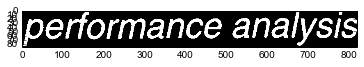

In [30]:
image = imread("book/0005/010001.bin.png")
image = 1-mean(image,2)
with codecs.open("book/0005/010001.gt.txt","r","utf-8") as stream: 
    gt = stream.read().strip()
transcript = [encode[c] for c in gt]
imshow(image,cmap=cm.gray)
print gt
print transcript

Let's loop through the images we want to store. Note that store the _transpose_ of the image, since we want the sequence recognizer to step through the colums of the text line from left to right.

In [31]:
index = 0
charset = set()
for fname in sorted(glob.glob("book/*/*.bin.png")):
    gtname = re.sub(r'.bin.png$', '.gt.txt', fname)
    with codecs.open(gtname,"r","utf-8") as stream:
        gt = stream.read().strip()
    image = imread(fname)
    image = 1-mean(image,2)
    images[index] = image.T.ravel()
    images_dims[index] = image.T.shape
    transcript = [encode[c] for c in gt]
    transcripts[index] = transcript
    keys[index] = fname
    index += 1
print index

500


That's it, we can close the dataset now.

In [32]:
h5.close()

There are a number of command line tools for checking our work.

In [33]:
!h5ls uw3-500.h5

codec                    Dataset {83}
images                   Dataset {500/Inf}
images_dims              Dataset {500/Inf, 2}
keys                     Dataset {500/Inf}
transcripts              Dataset {500/Inf}


# Reading HDF5 Training Files

The code below shows how to read the training files we created above.

In [34]:
h5 = h5py.File("uw3-500.h5", "r")

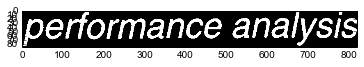

In [35]:
imshow(h5["images"][0].reshape(*h5["images_dims"][0]).T,cmap=cm.gray)

In [36]:
print h5["keys"][0]

book/0005/010001.bin.png


In [37]:
print [chr(h5["codec"][x]) for x  in h5["transcripts"][0]]

['p', 'e', 'r', 'f', 'o', 'r', 'm', 'a', 'n', 'c', 'e', ' ', 'a', 'n', 'a', 'l', 'y', 's', 'i', 's']


In [38]:
h5.close()

# CLSTM training

Let's build the CLSTM library and command line tools.

In [39]:
!(cd .. && scons)

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
g++ --std=c++11 -Wno-unused-result -o clstm.o -c -g -O3 -finline -g -Dadd_raw=add -I/usr/include/eigen3 clstm.cc
g++ --std=c++11 -Wno-unused-result -o clstmconv.o -c -g -O3 -finline -g -Dadd_raw=add -I/usr/include/eigen3 clstmconv.cc
g++ --std=c++11 -Wno-unused-result -o extras.o -c -g -O3 -finline -g -Dadd_raw=add -I/usr/include/eigen3 extras.cc
ar rc libclstm.a clstm.o extras.o
ranlib libclstm.a
g++ --std=c++11 -Wno-unused-result -o clstmconv clstmconv.o version.h libclstm.a -lhdf5_cpp -lhdf5 -lzmqpp -lzmq -lpng
g++ --std=c++11 -Wno-unused-result -o clstmctc.o -c -g -O3 -finline -g -Dadd_raw=add -I/usr/include/eigen3 clstmctc.cc
g++ --std=c++11 -Wno-unused-result -o clstmctc clstmctc.o version.h libclstm.a -lhdf5_cpp -lhdf5 -lzmqpp -lzmq -lpng
g++ --std=c++11 -Wno-unused-result -o clstmimg.o -c -g -O3 -finline -g -Dadd_raw=add -I/usr/include/eigen3 clstmimg.cc
g++ --std=c++11 -Wno-un

Let's now run `clstmctc` training. We report every 100 training steps. Since we didn't dewarp or size-normalize the lines, we need to use a `dewarp=center` argument to training.

In [40]:
!dewarp=center report_every=500 save_name=test save_every=10000 ntrain=11000 ../clstmctc uw3-500.h5

params hg_version 8ac7c757624f+ lrate 0.0001 nhidden 100 nhidden2 -1 pseudo_batch 1 momentum 0.9 type BIDILSTM LSTM SoftmaxLayer
center_normalizer 4 1 0.3
dataset 500 48 center
0 457 dim 143 48 time 0.00559688 lrate 0.0001 hidden 100 -1
TRU: 'process.'
OUT: ''
ALN: ''
8
500 229 dim 831 48 time 184.305 lrate 0.0001 hidden 100 -1
TRU: 'bearing, high-grade (low-pressure granulite fa-'
OUT: '    a                     a                  a'
ALN: 'eaariing, high-rade (low-pressure granulite fa-'
42
1000 247 dim 958 48 time 359.314 lrate 0.0001 hidden 100 -1
TRU: 'knowledge encoded in them, and their use and re-use'
OUT: ' ennen  ee neenneene ee  ant nennnanne t nennenennne neene'
ALN: 'knnnowwwledgge enencoded inn them,  and thheir use and re-use'
41
1500 459 dim 834 48 time 542.169 lrate 0.0001 hidden 100 -1
TRU: 'that the constraint does not support a pair of'
OUT: 'thn ttheoonstnnintdoesnetsnnttcttannnno'
ALN: 'thaatthe constraint doe  not uupport pairof'
24
2000 13 dim 156 48 time 716.686